# 5 modes Injection Quantum Linear Optics reservoir applied to wind-produced energy data and NARMA sequence

In [2]:
# Libraries importation

import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import perceval as pcvl # for perceval algorithm
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.preprocessing import PolynomialFeatures # for polynomial regression
from tqdm import tqdm # for progress bar

In [3]:
# Reservoir functions

def set_processor_parameters(processor, parameter_matrix):
    """Set the parameters of the processor to the values in the matrix.

    Args:
        processor (Processor): The processor to set the parameters for.
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = list(processor.get_circuit_parameters().values())
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

# Wind-produced energy data

In [4]:
df = pd.read_csv("wind_data_fr_2021.csv", sep=";") # csv loading

da = np.array(df["Eolien (MW)"]) # np array creation from csv

da_scaled = da[5:105] # scaled array for comparison
da = da[5:105] # removing the first 5 values

da = da.reshape(-1,1) # reshaping the array

data = da # create the data array

Text(0.5, 1.0, 'Wind power production (50 hours)')

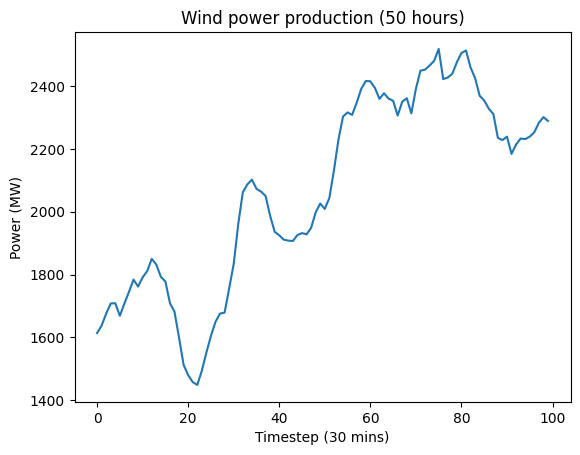

In [5]:
# plot data
plt.plot(da_scaled)
# legend x axis
plt.xlabel("Timestep (30 mins)")
# legend y axis
plt.ylabel("Power (MW)")
# title
plt.title("Wind power production (50 hours)")

In [6]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_PHOTON_NUMBER = 2
INIT_STATE = [0, 0, 0, 0, 0] + [INIT_PHOTON_NUMBER]
print(f"Init state for new run {INIT_STATE}")
E_PROBABILITY = 0.7
MULTIPHOTON_COMPONENT = 0.1
SCALE = 0.01
LOSS = 0.4
BS_INDEX = [3,2,1,0] #+ random_indices_with_repeats(N_MODES-1, 2*(N_MODES-1))
print("Beamsplitter arrangement", BS_INDEX)

# Normalize data
data_renormalized = (data - min(data)[0]) / (max(data)[0] - min(data)[0])
# data_renorm_red = data_renormalized[::10]

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))
parameter_matrix = np.ones(len(BS_INDEX)) * np.pi 

# Main loop for circuit construction and simulation
for i in tqdm(range(len(data_renormalized)), desc="Computing layer"):
    processor = pcvl.Processor("SLOS", len(INIT_STATE))
    # Add circuit beam splitters and connector to ancilla
    # processor.add(N_MODES, pcvl.BS(theta=2 * np.pi * data_renormalized[i]))
    # angle = 2 * np.arccos(np.sqrt(data_renrmalized[i]))
    angle = data_renormalized[i]*2*np.pi
    print(f"Angle {angle}")
    # angle = 0
    processor.add(N_MODES-1, pcvl.BS().add(0, pcvl.PS(phi=angle)).add(0, pcvl.BS()))
    print(f"Prob for upper {np.cos(angle/2)**2}")
    # add BS cascade to ensure full connectivity and add random BS
    for j, index in enumerate(BS_INDEX):
        processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
    # add loss channel to each mode
    for k in range(N_MODES):
        processor.add(k, pcvl.LC(LOSS))

    # parameter_matrix = np.random.normal(loc=data_renormalized[i], scale=SCALE, size=len(BS_INDEX)) * 2 * np.pi
    set_processor_parameters(processor, parameter_matrix)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    # prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i,:] = expectations
    # print(f"Expectations {expectations}")
    print(f"Most probable state: {max(prob_distribution, key=prob_distribution.get)}")
    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [INIT_PHOTON_NUMBER]
    print(f"Init state for new run {INIT_STATE}")

# Display the final circuit
print("Expectation matrix shape", expectation_matrix.shape)
print("Final circuit")
#pcvl.pdisplay(processor, recursive=True)

Init state for new run [0, 0, 0, 0, 0, 2]
Beamsplitter arrangement [3, 2, 1, 0]


Computing layer:   4%|▍         | 4/100 [00:00<00:02, 34.65it/s]

Angle [0.96980877]
Prob for upper [0.78272863]
Most probable state: |2,0,0,0,0,0>
Init state for new run [2, 0, 0, 0, 0, 2]
Angle [1.11087186]
Prob for upper [0.72194021]
Most probable state: |1,2,0,0,0,1>
Init state for new run [1, 2, 0, 0, 0, 2]
Angle [1.33422176]
Prob for upper [0.61718699]
Most probable state: |1,1,2,0,0,1>
Init state for new run [1, 1, 2, 0, 0, 2]
Angle [1.52230589]
Prob for upper [0.52423572]
Most probable state: |1,1,1,2,0,1>
Init state for new run [1, 1, 1, 2, 0, 2]
Angle [1.52818352]
Prob for upper [0.52129996]
Most probable state: |1,1,1,1,2,1>
Init state for new run [1, 1, 1, 1, 2, 2]
Angle [1.29307836]
Prob for upper [0.63708088]
Most probable state: |0,1,1,1,1,4>
Init state for new run [0, 1, 1, 1, 1, 2]
Angle [1.52230589]
Prob for upper [0.52423572]


Computing layer:  20%|██        | 20/100 [00:00<00:02, 34.93it/s]

Most probable state: |0,0,1,1,1,3>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle [1.73977816]
Prob for upper [0.41591062]
Most probable state: |0,0,0,1,1,3>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle [1.96900569]
Prob for upper [0.30611579]
Most probable state: |0,0,0,0,1,3>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle [1.83969785]
Prob for upper [0.3671637]
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [2.01014909]
Prob for upper [0.28732311]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [2.12770167]
Prob for upper [0.23571915]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [2.35692919]
Prob for upper [0.14618695]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [2.25113187]
Prob for upper [0.18547305]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [2.02190435]
Prob for upper [0.28201851]
Most prob

Computing layer:  25%|██▌       | 25/100 [00:08<00:34,  2.17it/s]

Most probable state: |1,2,2,2,2,3>
Init state for new run [1, 2, 2, 2, 2, 2]
Angle [0.91691011]
Prob for upper [0.80413779]
Most probable state: |1,1,2,2,2,3>
Init state for new run [1, 1, 2, 2, 2, 2]
Angle [1.18140341]
Prob for upper [0.68981342]
Most probable state: |0,1,1,2,2,4>
Init state for new run [0, 1, 1, 2, 2, 2]
Angle [1.33422176]
Prob for upper [0.61718699]
Most probable state: |0,0,1,1,2,4>
Init state for new run [0, 0, 1, 1, 2, 2]
Angle [1.35185465]
Prob for upper [0.60859834]


Computing layer:  39%|███▉      | 39/100 [00:10<00:16,  3.78it/s]

Most probable state: |0,0,0,1,1,4>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle [1.80443208]
Prob for upper [0.38424199]
Most probable state: |0,0,0,0,1,3>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle [2.26288713]
Prob for upper [0.18092584]
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.009346]
Prob for upper [0.00436593]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.60298652]
Prob for upper [0.05228359]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.74992725]
Prob for upper [0.08969953]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.83809168]
Prob for upper [0.11645356]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.66764044]
Prob for upper [0.06760085]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [3.61474178]
Prob for upper [0.05493116]
Most proba

Computing layer:  59%|█████▉    | 59/100 [00:10<00:04,  9.19it/s]

Angle [3.4971892]
Prob for upper [0.03128052]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.00854292]
Prob for upper [0.17642273]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.59042818]
Prob for upper [0.43917066]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [5.01949509]
Prob for upper [0.65115071]
Most probable state: |1,0,0,0,0,1>
Init state for new run [1, 0, 0, 0, 0, 2]
Angle [5.09590427]
Prob for upper [0.68709135]
Most probable state: |1,1,0,0,0,1>
Init state for new run [1, 1, 0, 0, 0, 2]
Angle [5.04888324]
Prob for upper [0.66509]
Most probable state: |1,1,1,0,0,1>
Init state for new run [1, 1, 1, 0, 0, 2]
Angle [5.27811076]
Prob for upper [0.76801264]
Most probable state: |1,1,1,1,0,1>
Init state for new run [1, 1, 1, 1, 0, 2]
Angle [5.53672644]
Prob for upper [0.86704902]
Most probable state: |2,1,1,1,1,0>
Init state for new run [2, 1, 1, 1, 1, 2]
Angle [5.683

Computing layer:  72%|███████▏  | 72/100 [00:14<00:04,  5.85it/s]

Most probable state: |0,1,1,1,1,3>
Init state for new run [0, 1, 1, 1, 1, 2]
Angle [5.29574365]
Prob for upper [0.77541345]
Most probable state: |1,0,1,1,1,2>
Init state for new run [1, 0, 1, 1, 1, 2]
Angle [5.36039757]
Prob for upper [0.80179994]
Most probable state: |1,1,0,1,1,2>
Init state for new run [1, 1, 0, 1, 1, 2]
Angle [5.07827138]
Prob for upper [0.67888671]
Most probable state: |0,1,1,0,1,3>
Init state for new run [0, 1, 1, 0, 1, 2]
Angle [5.53672644]
Prob for upper [0.86704902]
Most probable state: |1,0,1,1,0,2>
Init state for new run [1, 0, 1, 1, 0, 2]
Angle [5.87762891]
Prob for upper [0.95944151]
Most probable state: |2,1,0,1,1,0>
Init state for new run [2, 1, 0, 1, 1, 2]
Angle [5.8952618]
Prob for upper [0.96284826]
Most probable state: |2,2,1,0,1,1>
Init state for new run [2, 2, 1, 0, 1, 2]
Angle [5.97167097]
Prob for upper [0.97593526]
Most probable state: |2,2,2,1,0,1>
Init state for new run [2, 2, 2, 1, 0, 2]
Angle [6.05983541]
Prob for upper [0.98758046]
Most prob

Computing layer:  77%|███████▋  | 77/100 [00:19<00:07,  2.89it/s]

Most probable state: |1,2,2,2,2,3>
Init state for new run [1, 2, 2, 2, 2, 2]
Angle [5.74832108]
Prob for upper [0.93016892]
Most probable state: |1,1,2,2,2,3>
Init state for new run [1, 1, 2, 2, 2, 2]
Angle [5.81885262]
Prob for upper [0.9470603]
Most probable state: |2,1,1,2,2,2>
Init state for new run [2, 1, 1, 2, 2, 2]
Angle [6.03632489]
Prob for upper [0.9848422]
Most probable state: |2,2,1,1,2,2>
Init state for new run [2, 2, 1, 1, 2, 2]
Angle [6.20677613]
Prob for upper [0.99854112]


Computing layer:  81%|████████  | 81/100 [00:22<00:08,  2.16it/s]

Most probable state: |2,2,2,1,1,2>
Init state for new run [2, 2, 2, 1, 1, 2]
Angle [6.25379716]
Prob for upper [0.9997841]
Most probable state: |2,2,2,2,1,1>
Init state for new run [2, 2, 2, 2, 1, 2]
Angle [5.9364052]
Prob for upper [0.97023597]
Most probable state: |2,2,2,2,2,1>
Init state for new run [2, 2, 2, 2, 2, 2]
Angle [5.73656582]
Prob for upper [0.9271433]


Computing layer:  84%|████████▍ | 84/100 [00:27<00:10,  1.51it/s]

Most probable state: |1,2,2,2,2,3>
Init state for new run [1, 2, 2, 2, 2, 2]
Angle [5.4074186]
Prob for upper [0.82020409]
Most probable state: |1,1,2,2,2,3>
Init state for new run [1, 1, 2, 2, 2, 2]
Angle [5.31925417]
Prob for upper [0.7851476]


Computing layer:  86%|████████▌ | 86/100 [00:29<00:10,  1.37it/s]

Most probable state: |1,1,1,2,2,3>
Init state for new run [1, 1, 1, 2, 2, 2]
Angle [5.16643581]
Prob for upper [0.71930296]


Computing layer:  88%|████████▊ | 88/100 [00:30<00:07,  1.55it/s]

Most probable state: |0,1,1,1,2,4>
Init state for new run [0, 1, 1, 1, 2, 2]
Angle [5.06651612]
Prob for upper [0.6733859]
Most probable state: |0,0,1,1,1,4>
Init state for new run [0, 0, 1, 1, 1, 2]
Angle [4.61981633]
Prob for upper [0.45377975]
Most probable state: |0,0,0,1,1,3>
Init state for new run [0, 0, 0, 1, 1, 2]
Angle [4.57867292]
Prob for upper [0.43334103]
Most probable state: |0,0,0,0,1,3>
Init state for new run [0, 0, 0, 0, 1, 2]
Angle [4.64332684]
Prob for upper [0.46549637]
Most probable state: |0,0,0,0,0,3>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.32005725]
Prob for upper [0.30882799]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.49638612]
Prob for upper [0.39283645]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.60806107]
Prob for upper [0.44793062]
Most probable state: |0,0,0,0,0,2>
Init state for new run [0, 0, 0, 0, 0, 2]
Angle [4.59630581]
Prob for upper [0.44208868]
Most prob

Computing layer: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]

Most probable state: |1,1,0,0,0,1>
Init state for new run [1, 1, 0, 0, 0, 2]
Angle [4.90194251]
Prob for upper [0.59421022]
Most probable state: |1,1,1,0,0,1>
Init state for new run [1, 1, 1, 0, 0, 2]
Angle [5.00773983]
Prob for upper [0.64553776]
Most probable state: |1,1,1,1,0,1>
Init state for new run [1, 1, 1, 1, 0, 2]
Angle [4.93720829]
Prob for upper [0.61146511]
Most probable state: |1,1,1,1,1,1>
Init state for new run [1, 1, 1, 1, 1, 2]
Expectation matrix shape (100, 5)
Final circuit


In [7]:
output_array = expectation_matrix

# Linear regression

Text(0.5, 1.0, 'Linear Regression (Wind) (50 hours) (100% train)')

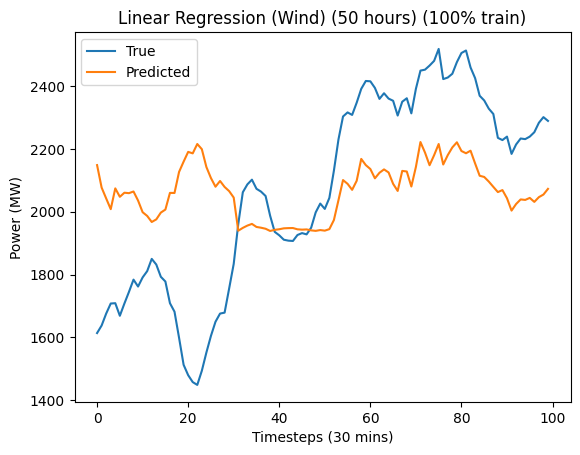

In [8]:
reg = LinearRegression().fit(output_array, da_scaled) # linear regression fit
reg.predict(output_array) # prediction

# plot true data
plt.plot(da_scaled, label="True")
# plot predicted data
plt.plot(reg.predict(output_array), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Linear Regression (Wind) (50 hours) (100% train)")

In [9]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(output_array, da_scaled, test_size=0.5)

Text(0.5, 1.0, 'Linear Regression (Wind) (25 hours) (50% train, 50% test)')

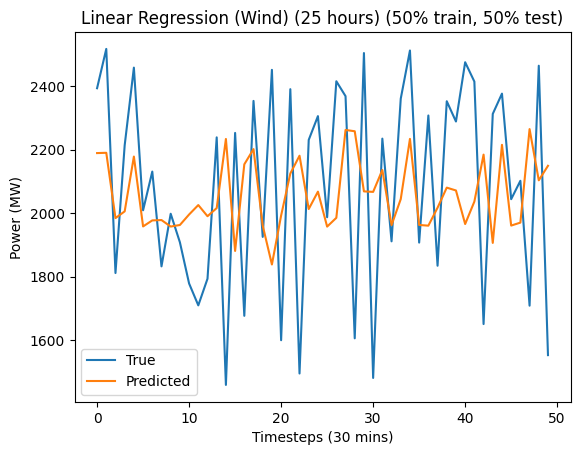

In [10]:
reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Linear Regression (Wind) (25 hours) (50% train, 50% test)")

# Polynomial regression

Text(0.5, 1.0, 'Polynomial Regression (Wind) (25 hours) (50% train, 50% test)')

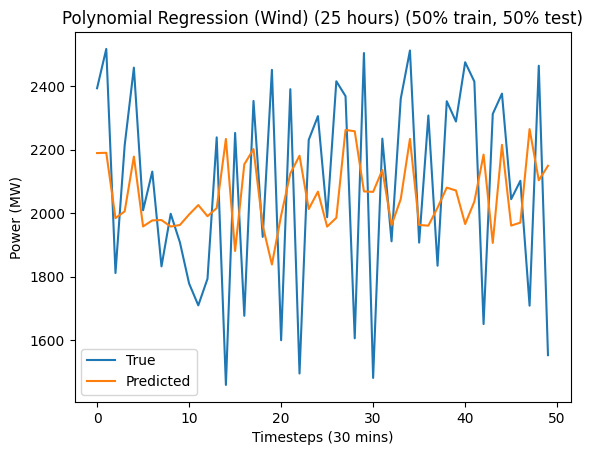

In [17]:
poly = PolynomialFeatures(2) # set the degree of the polynomial
output_array_poly = poly.fit_transform(output_array) # transform the output array

reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Polynomial Regression (Wind) (25 hours) (50% train, 50% test)")